# Imports

In [1]:
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Normalização

In [2]:
data_frame = pd.read_csv('Admission_Predict_Ver1.1.csv')
mediaChance = data_frame['Chance of Admit '].mean()

In [3]:
data_frame['GRE Score'] = data_frame['GRE Score'] / data_frame['GRE Score'].max()
data_frame['TOEFL Score'] = data_frame['TOEFL Score'] / data_frame['TOEFL Score'].max()
data_frame['University Rating'] = data_frame['University Rating'] / data_frame['University Rating'].max()
data_frame['SOP'] = data_frame['SOP'] / data_frame['SOP'].max()
data_frame['LOR '] = data_frame['LOR '] / data_frame['LOR '].max()
data_frame['CGPA'] = data_frame['CGPA'] / data_frame['CGPA'].max()

In [4]:
x = data_frame.drop(['Serial No.', 'Research', 'Chance of Admit '], axis=1)[['GRE Score', 'TOEFL Score', 'CGPA','SOP', 'LOR ', 'University Rating']]
y = data_frame['Chance of Admit ']
x = scale(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [5]:
data_frame[(data_frame[['Chance of Admit ']] >= mediaChance)] = 1
data_frame[(data_frame[['Chance of Admit ']] < mediaChance)] = 0

data_frame.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,0.991176,0.983333,0.8,0.9,0.9,0.972782,1,1.0
1,2,0.952941,0.891667,0.8,0.8,0.9,0.894153,1,1.0
2,3,0.929412,0.866667,0.6,0.6,0.7,0.806452,1,0.0
3,4,0.947059,0.916667,0.6,0.7,0.5,0.873992,1,1.0
4,5,0.923529,0.858333,0.4,0.4,0.6,0.827621,0,0.0


# SOM

In [6]:
size = 6
som = MiniSom(size, size, len(x[0]) , neighborhood_function='bubble', sigma=1, learning_rate = 0.5, random_seed=1)

In [7]:
som.pca_weights_init(x)
som.train_batch(x, 100, verbose=True)

 [ 100 / 100 ] 100% 0.00078 it/s

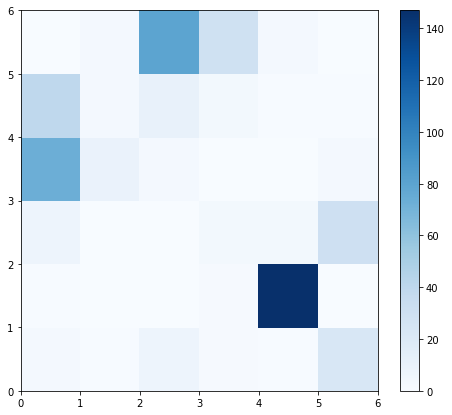

In [8]:
plt.figure(figsize=(8, 7))
frequencies = np.zeros((size, size))
for position, values in som.win_map(x).items():
    frequencies[position[0], position[1]] = len(values)
plt.pcolor(frequencies, cmap='Blues')
plt.colorbar()
plt.show()


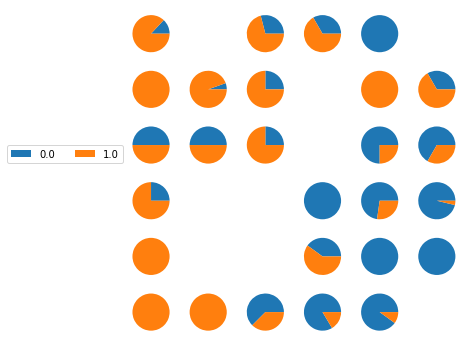

In [9]:
labels_map = som.labels_map(x, y)
label_names = np.unique(y)

plt.figure(figsize=(7, 7))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0, 3), ncol=3)
plt.show()

# K-Means

In [17]:
kmeans = KMeans(n_clusters = 2, init = 'random')

In [18]:
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
kmeans.cluster_centers_

array([[-0.70443562, -0.68357288, -0.73657562, -0.69489401, -0.61574554,
        -0.67659014],
       [ 0.75100988,  0.72876778,  0.78527484,  0.74083741,  0.65645599,
         0.72132337]])

In [20]:
distance = kmeans.fit_transform(x)
distance

array([[1.87544217, 5.19090685],
       [0.94092748, 3.24036359],
       [2.76861938, 1.14965646],
       [2.15428805, 2.15809848],
       [3.7215061 , 0.91382439],
       [1.77396933, 4.48238294],
       [2.07264979, 1.98726239],
       [3.63306927, 1.35942554],
       [5.37703626, 2.15936757],
       [1.86085327, 1.96322126],
       [1.76774918, 2.21103657],
       [0.49818124, 3.6246689 ],
       [0.52554578, 3.79322493],
       [2.81560023, 1.75667373],
       [3.37573478, 1.43032092],
       [2.79387773, 1.25966689],
       [1.88854522, 1.97543188],
       [2.51499399, 1.78986194],
       [1.66444959, 2.29167776],
       [3.11287326, 1.27839137],
       [3.56685612, 1.43325183],
       [2.79056951, 2.94373952],
       [1.92534174, 5.33097187],
       [2.2495798 , 5.68536266],
       [2.28501344, 5.27335782],
       [2.37507758, 5.74103367],
       [1.36675172, 3.5571673 ],
       [5.50715783, 2.11063525],
       [6.50765403, 3.08373101],
       [5.44314726, 2.21945063],
       [4.

1 3000.0
2 1493.6640513792734
3 1124.4618099892978
4 979.5149412929693
5 874.6845036219394
6 812.3455527975015
7 757.4903179893695
8 716.6930997191396
9 682.779886848132


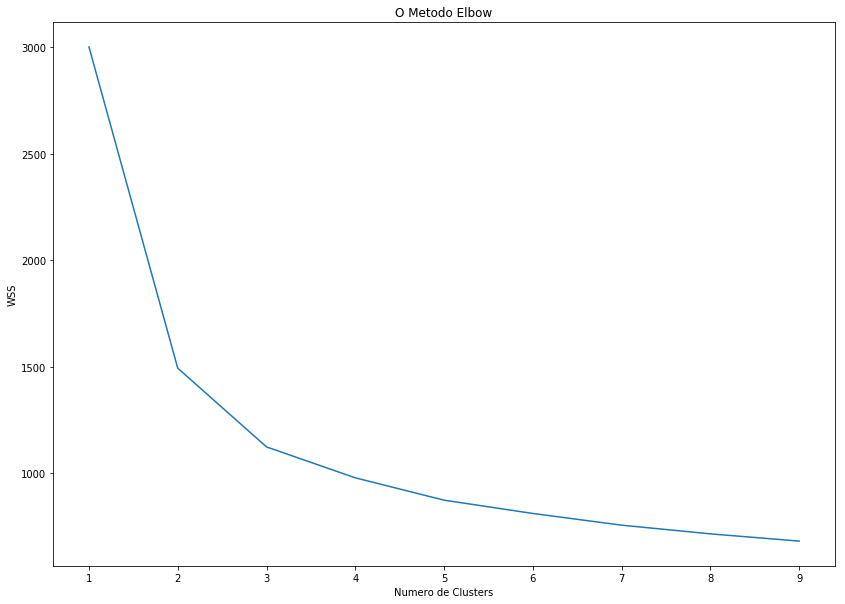

In [40]:
wcss = []
 
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(x)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)
    
plt.rcParams['figure.figsize'] = (14,10)
plt.plot(range(1, 10), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

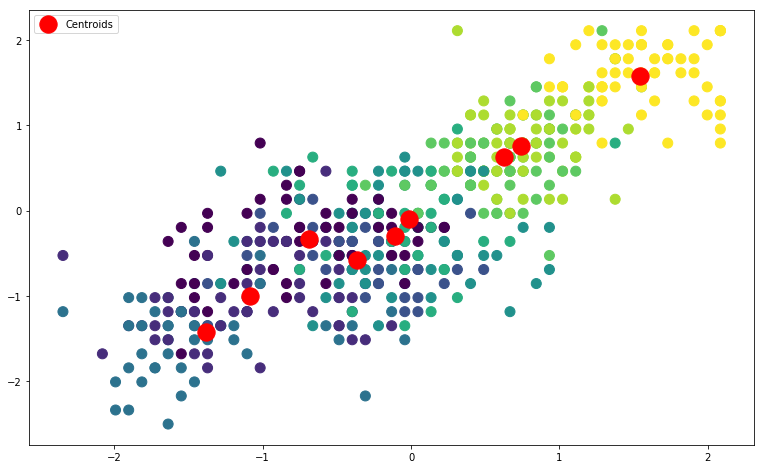

In [46]:
plt.rcParams['figure.figsize'] = (13,8)
plt.scatter(x[:, 0], x[:, 1], s = 100, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Centroids')
plt.legend()

plt.show()

# Hierárquico